# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

### Описание данных

#### Технологический процесс
Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

#### Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

#### Наименование признаков

Наименование признаков должно быть такое:

$[этап].[тип_параметра].[название_параметра]$

Пример: [rougher.input.feed_ag]

Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]:

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

### Расчёт эффективности

Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле:

<div style="text-align: center;"> $Recovery = (C x (F - T) / F x (C - T)) * 100$ </div>
    
где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

### Метрика качества

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

<div style="text-align: center;"> $sMAPE = 1/N * Sum_1^N ( (|y_i - y_i^-|) / ( (|y_i| + |y_i^-|)/2) ) * 100$ </div>
    
где:
- Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество - y_i;
- Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке - y_i^-;

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

# 1. Подготовка данных

1.1. Открываем файлы и изучаем их.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train = pd.read_csv('gold_recovery_train.csv')
test = pd.read_csv('gold_recovery_test.csv')
full = pd.read_csv('gold_recovery_full.csv')

In [4]:
# функция проверки наличия пропусков и дубликатов

def preview(data):
    
    print(data.isnull().sum())
    print()
    print('Количество дубликатов: {}'.format(data.duplicated().sum()))
    

In [5]:
preview(train)

date                                                     0
final.output.concentrate_ag                             72
final.output.concentrate_pb                             72
final.output.concentrate_sol                           370
final.output.concentrate_au                             71
final.output.recovery                                 1521
final.output.tail_ag                                    66
final.output.tail_pb                                   183
final.output.tail_sol                                  145
final.output.tail_au                                    66
primary_cleaner.input.sulfate                         1307
primary_cleaner.input.depressant                      1262
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         985
primary_cleaner.output.concentrate_ag                   82
primary_cleaner.output.concentrate_pb                  358
primary_cleaner.output.concentrate_sol                 6

In [6]:
train.head().T # смотрим первые пять экземпляров и все признаки

,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.0554,6.02937,6.05593,6.04798,6.1486
final.output.concentrate_pb,9.88965,9.96894,10.214,9.97702,10.1425
final.output.concentrate_sol,5.50732,5.25778,5.38376,4.85863,4.93942
final.output.concentrate_au,42.192,42.7016,42.6575,42.6898,42.7741
final.output.recovery,70.5412,69.2662,68.1164,68.3475,66.927
final.output.tail_ag,10.412,10.4627,10.507,10.4228,10.3603
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.9043,16.6345,16.2088,16.5328,16.5257
final.output.tail_au,2.14315,2.22493,2.25789,2.14685,2.05529


In [7]:
train.info() # смотрим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


В трейне есть пропуски во многих признаках. Дубликатов нет. Дату нужно привести в нужный формат.

In [8]:
preview(test)

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [9]:
test.head().T

,0,1,2,3,4
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.801,215.392,215.26,215.336,199.099
primary_cleaner.input.depressant,14.9931,14.9875,12.8849,12.0068,10.6825
primary_cleaner.input.feed_size,8.08,8.08,7.78667,7.64,7.53
primary_cleaner.input.xanthate,1.00502,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.98,1398.78,1398.49,1399.62,1401.27
primary_cleaner.state.floatbank8_a_level,-500.226,-500.057,-500.868,-498.864,-500.808
primary_cleaner.state.floatbank8_b_air,1399.14,1398.06,1398.86,1397.44,1398.13
primary_cleaner.state.floatbank8_b_level,-499.92,-499.778,-499.765,-499.211,-499.505
primary_cleaner.state.floatbank8_c_air,1400.1,1396.15,1398.08,1400.13,1402.17


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

В тесте есть пропуски во многих признаках. Дубликатов нет. Дату нужно привести в нужный формат.

In [11]:
preview(full)

date                                                     0
final.output.concentrate_ag                             89
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.concentrate_au                             86
final.output.recovery                                 1963
final.output.tail_ag                                    83
final.output.tail_pb                                   200
final.output.tail_sol                                  271
final.output.tail_au                                    81
primary_cleaner.input.sulfate                         1609
primary_cleaner.input.depressant                      1546
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                        1151
primary_cleaner.output.concentrate_ag                   98
primary_cleaner.output.concentrate_pb                  448
primary_cleaner.output.concentrate_sol                 7

In [12]:
full.head().T

,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.0554,6.02937,6.05593,6.04798,6.1486
final.output.concentrate_pb,9.88965,9.96894,10.214,9.97702,10.1425
final.output.concentrate_sol,5.50732,5.25778,5.38376,4.85863,4.93942
final.output.concentrate_au,42.192,42.7016,42.6575,42.6898,42.7741
final.output.recovery,70.5412,69.2662,68.1164,68.3475,66.927
final.output.tail_ag,10.412,10.4627,10.507,10.4228,10.3603
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
final.output.tail_sol,16.9043,16.6345,16.2088,16.5328,16.5257
final.output.tail_au,2.14315,2.22493,2.25789,2.14685,2.05529


In [13]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [14]:
train.shape, test.shape, full.shape

((16860, 87), (5856, 53), (22716, 87))

**Заполним пропуски до последующих действий для избежания дополнительной работы**

Для понимания как заполнить пропуски посмотрим еще раз на данные - на даты и значения признаков при них.

In [15]:
train.sample(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
3073,2016-05-22 00:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,24.103969,NaN,7.77,0.080127,1.941464,NaN,NaN,13.377021,10.071699,1.396807,NaN,2.697743,1.331768e+03,-552.041091,1.331771e+03,-551.154310,1.330513e+03,-582.429730,1.330356e+03,-629.904910,-2.785531e+06,240073.665186,297084.424840,2.624538,0.211762,0.074686,166.004730,30.633673,0.726881,0.196016,7.036146,3.201533,7.243849,3.216069,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.207590,NaN,NaN,998.924511,-502.050826,999.200085,-497.340246,999.012565,-497.688023,950.125120,-499.471186,900.542542,-498.579849,800.356735,-496.568686,5.633999,1.545091,NaN,1.674637,27.493501,-346.155530,2.621719e+01,-502.320110,26.877111,-498.754914,25.004176,-478.567381,11.993237,-500.567289,10.889826,-501.241152,11.546093,-551.267585,9.846945,-549.562206,20.041417,-600.640083
10271,2017-07-17 22:59:59,6.215215,11.781757,11.675390,40.677659,66.714600,7.700123,3.036730,11.448047,2.765958,150.421851,6.001768,7.80,0.608740,8.906492,12.351735,10.580695,31.450086,12.896218,1.893286,7.4174

In [16]:
train[train['rougher.input.feed_au'] == 0].sample(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
11444,2018-01-04 19:59:59,5.172451,9.456323,12.837851,46.196126,NaN,11.37964,2.822303,7.826585,3.909797,56.141086,6.059054,7.70,0.391495,7.706495,9.909341,9.026558,34.847804,21.005184,5.306741,5.99833,3.433697,1.498052e+03,-500.213551,1.504167e+03,-499.957756,1.423079e+03,-500.164924,1.500403e+03,-505.193737,48010.719326,7289.468092,2.183476,NaN,0.0,0.0,199.738193,97.083977,0.0,0.0,9.999159,5.497471,0.002673,NaN,0.0,0.0,0.0,0.0,NaN,6.060067,0.978919,17.923847,2.613788,1402.498415,-300.232059,1201.526536,-499.977992,1102.171985,-499.945671,1007.066495,-500.503626,999.498540,-500.162148,1000.062842,-500.142753,0.0,0.0,0.0,0.0,1.968086,-780.216623,1.860404e-01,-799.656829,2.796450e+01,-500.130949,2.297822e+01,-499.930579,2.001197e+01,-500.289048,1.501921e+01,-499.800925,10.962075,-500.312406,8.999849,-500.066249,10.988025,-500.333813
7574,2017-03-27 13:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.00000,0.000000,0.000000,0.000000,NaN,NaN,6.66,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.696025e+03,-500.191588,1.705678e+03,-79

**Есть связь некоторых расчетных величин от значений других признаков, однако, прямую зависимость выстроить не получиться. Поэтому для простоты заменить пропущенные значения на медианы**

In [17]:
train['date'] = pd.to_datetime(train['date'])

In [18]:
for i in train.columns:
    train[i].fillna(train[i].mean(), inplace=True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16860 non-null  float64       
 2   final.output.concentrate_pb                         16860 non-null  float64       
 3   final.output.concentrate_sol                        16860 non-null  float64       
 4   final.output.concentrate_au                         16860 non-null  float64       
 5   final.output.recovery                               16860 non-null  float64       
 6   final.output.tail_ag                                16860 non-null  float64       
 7   final.output.tail_pb                                16860 non-null  float64       
 8   final.

1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака ***rougher.output.recovery***. Найдем MAE между нашими расчётами и значением признака. Опишим выводы.

Напомним формулу:

<div style="text-align: center;"> $Recovery = (C x (F - T) / F x (C - T)) * 100$ </div>
    
где:
- C — доля золота в концентрате после флотации/очистки; **- rougher.output.concentrate_au**
- F — доля золота в сырье/концентрате до флотации/очистки; **- rougher.input.feed_au**
- T — доля золота в отвальных хвостах после флотации/очистки. **- rougher.output.tail_au**

In [20]:
# создадим функцию расчета эффективности

def recovery(data):
    recovery = ((data['rougher.output.concentrate_au'] * (data['rougher.input.feed_au'] - data['rougher.output.tail_au'])) \
            / (data['rougher.input.feed_au'] * (data['rougher.output.concentrate_au'] - data['rougher.output.tail_au']))) * 100
    return recovery

In [21]:
train['rougher.output.concentrate_au'].sort_values()[:20]

8920    0.0
1995    0.0
1994    0.0
1993    0.0
1992    0.0
1991    0.0
1990    0.0
1989    0.0
1988    0.0
1987    0.0
1986    0.0
1985    0.0
1984    0.0
1983    0.0
1996    0.0
1982    0.0
1980    0.0
1979    0.0
1978    0.0
1929    0.0
Name: rougher.output.concentrate_au, dtype: float64

In [22]:
train['rougher.input.feed_au'].sort_values()[:20]

11444    0.0
3060     0.0
3061     0.0
3062     0.0
3063     0.0
3064     0.0
3065     0.0
3066     0.0
3067     0.0
3068     0.0
3069     0.0
3070     0.0
3071     0.0
3072     0.0
11455    0.0
11454    0.0
11453    0.0
11447    0.0
3059     0.0
3058     0.0
Name: rougher.input.feed_au, dtype: float64

In [23]:
recovery = recovery(train)

In [24]:
recovery.sort_values()[:20]

7071    -inf
11422   -inf
11423   -inf
11426   -inf
8587    -inf
11427   -inf
9977    -inf
9976    -inf
2573    -inf
11620   -inf
11619   -inf
11618   -inf
1150    -inf
1149    -inf
3083    -inf
3084    -inf
3085    -inf
3086    -inf
3087    -inf
3088    -inf
dtype: float64

**Так как в долях золота на входе и выходе после флотации есть значения равные 0, то формула в результатах расчетов выдает бесконечность - заменим эти значения на 0**

In [25]:
recovery = recovery.replace([np.inf, -np.inf], np.nan)
recovery.fillna(0, inplace=True)

In [26]:
recovery[:10]

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
5    88.156912
6    88.168065
7    87.668336
8    87.035862
9    87.650868
dtype: float64

In [27]:
train['rougher.output.recovery'][:10]

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
5    88.156912
6    88.168065
7    87.668336
8    87.035862
9    87.650868
Name: rougher.output.recovery, dtype: float64

In [28]:
len(recovery), recovery.dtype

(16860, dtype('float64'))

In [29]:
len(train['rougher.output.recovery']), train['rougher.output.recovery'].dtype

(16860, dtype('float64'))

In [30]:
# создадим формулу для расчета МАЕ

def mae(real, preds):
    return 1/len(real) * sum(abs(real - preds))

In [31]:
mae_val = mae(train['rougher.output.recovery'], recovery)
mae_val

58.752751448190935

Проверка метрикой sklearn

In [32]:
from sklearn.metrics import mean_absolute_error

In [33]:
mae = mean_absolute_error(train['rougher.output.recovery'], recovery)
mae

58.75275144818936

**Судя по небольшому значению МАЕ, относительно значений признака, можно сделать вывод, что в исходных данных признак посчитан правильно. Наша разница могла возникнуть в связи с заполнением пропусков.**

1.3. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

Посмотрим на количество признаков в тесте и трейне. Потом посмотрим каких признаков нет в тесте, но есть в трейне, для последующего отбора.

In [34]:
len(train.columns)

87

In [35]:
len(test.columns)

53

In [36]:
len(set(train.columns) - set(test.columns)), set(train.columns) - set(test.columns)

(34,
 {'final.output.concentrate_ag',
  'final.output.concentrate_au',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.recovery',
  'final.output.tail_ag',
  'final.output.tail_au',
  'final.output.tail_pb',
  'final.output.tail_sol',
  'primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.tail_ag',
  'primary_cleaner.output.tail_au',
  'primary_cleaner.output.tail_pb',
  'primary_cleaner.output.tail_sol',
  'rougher.calculation.au_pb_ratio',
  'rougher.calculation.floatbank10_sulfate_to_au_feed',
  'rougher.calculation.floatbank11_sulfate_to_au_feed',
  'rougher.calculation.sulfate_to_au_concentrate',
  'rougher.output.concentrate_ag',
  'rougher.output.concentrate_au',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.recovery',
  'rougher.output.tail_ag',
  'rougher.out

**Всего 34 признака. В тесте отсутствуют признаки финальных результатов, результатов процесса флотации, а также очисток первичной и вторичной (как данных по хвостам, концентрации веществ, так и данных по расчетным значениям веществ для флотации). Все это признаки для расчета модели - то есть для построения прогнозов.**

**Указанные признаки необходимо исключить из трейна перед обучением модели.**

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16860 non-null  float64       
 2   final.output.concentrate_pb                         16860 non-null  float64       
 3   final.output.concentrate_sol                        16860 non-null  float64       
 4   final.output.concentrate_au                         16860 non-null  float64       
 5   final.output.recovery                               16860 non-null  float64       
 6   final.output.tail_ag                                16860 non-null  float64       
 7   final.output.tail_pb                                16860 non-null  float64       
 8   final.

In [38]:
test['date'] = pd.to_datetime(test['date'])

In [39]:
for i in test.columns:
    test[i].fillna(test[i].mean(), inplace=True)

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64       
 9   primary_

In [41]:
full['date'] = pd.to_datetime(full['date'])

In [42]:
for i in full.columns:
    full[i].fillna(full[i].mean(), inplace=True)

In [43]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22716 non-null  float64       
 2   final.output.concentrate_pb                         22716 non-null  float64       
 3   final.output.concentrate_sol                        22716 non-null  float64       
 4   final.output.concentrate_au                         22716 non-null  float64       
 5   final.output.recovery                               22716 non-null  float64       
 6   final.output.tail_ag                                22716 non-null  float64       
 7   final.output.tail_pb                                22716 non-null  float64       
 8   final.

In [44]:
exclude = set(train.columns) - set(test.columns)
exclude = set(train.columns) - exclude
exclude

{'date',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

**Создадим датасет для модели только с признаками как в тесте. Проверим корректность построения датасета.**

In [45]:
train_to_model = train.loc[:, exclude]
print(set(train_to_model.columns) - exclude)
print(exclude - set(train_to_model.columns))

set()
set()


### Выводы по разделу:

В данных по трейну и тесту присутствют пропуски, дубликатов нет.

Провели преподготовку - заменили формат для даты, заполнили пропуски.

Проверили корректность расчетов эффективности - значение похоже на реальное.

# 2. Анализ данных

2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишим выводы.

In [46]:
full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

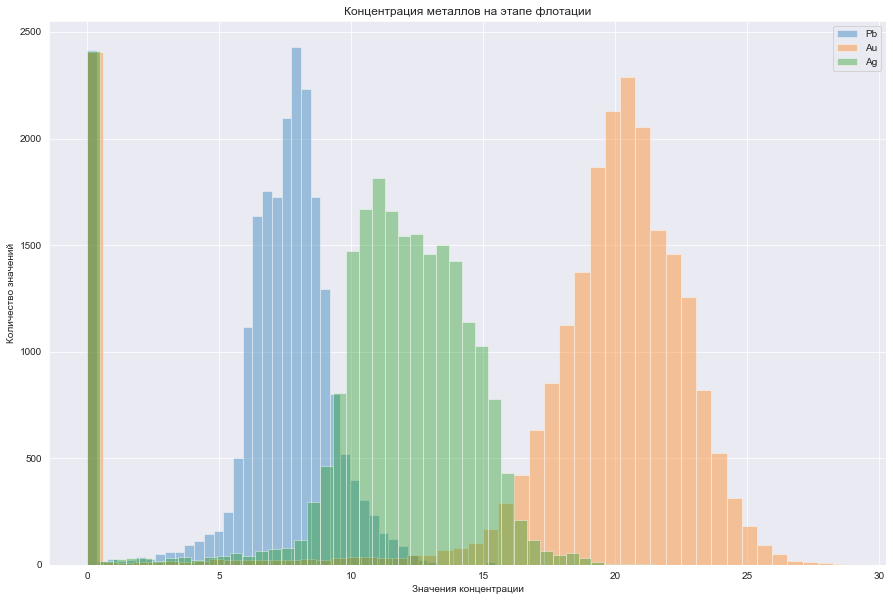

In [47]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

sns.distplot(full['rougher.output.concentrate_pb'], label='Pb', kde=False)
sns.distplot(full['rougher.output.concentrate_au'], label='Au', kde=False)
sns.distplot(full['rougher.output.concentrate_ag'], label='Ag', kde=False)
plt.legend()
plt.title('Концентрация металлов на этапе флотации')
plt.xlabel('Значения концентрации')
plt.ylabel('Количество значений');

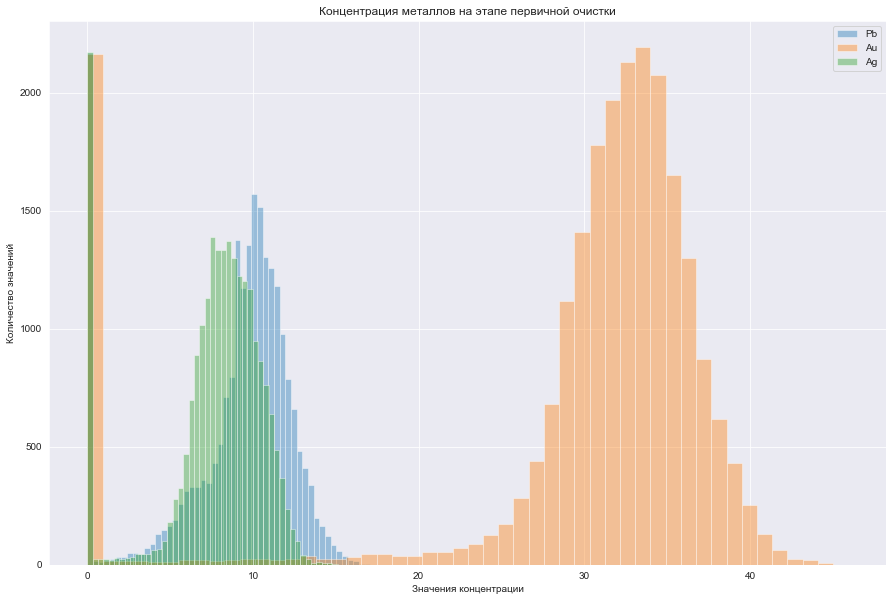

In [48]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

sns.distplot(full['primary_cleaner.output.concentrate_pb'], label='Pb', kde=False)
sns.distplot(full['primary_cleaner.output.concentrate_au'], label='Au', kde=False)
sns.distplot(full['primary_cleaner.output.concentrate_ag'], label='Ag', kde=False)
plt.legend()
plt.title('Концентрация металлов на этапе первичной очистки')
plt.xlabel('Значения концентрации')
plt.ylabel('Количество значений');

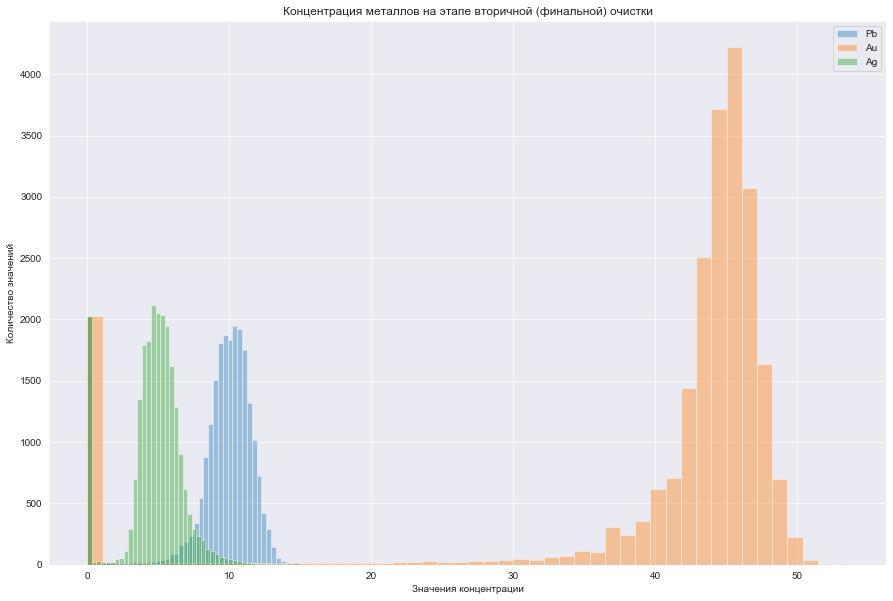

In [49]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

sns.distplot(full['final.output.concentrate_pb'], label='Pb', kde=False)
sns.distplot(full['final.output.concentrate_au'], label='Au', kde=False)
sns.distplot(full['final.output.concentrate_ag'], label='Ag', kde=False)
plt.legend()
plt.title('Концентрация металлов на этапе вторичной (финальной) очистки')
plt.xlabel('Значения концентрации')
plt.ylabel('Количество значений');

### Вывод:

Концентрация золота растет после каждого этапа очистки. Концентрация серебра и свинца остается примерно такой же как до очистки.

2.2. Сравниваем распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

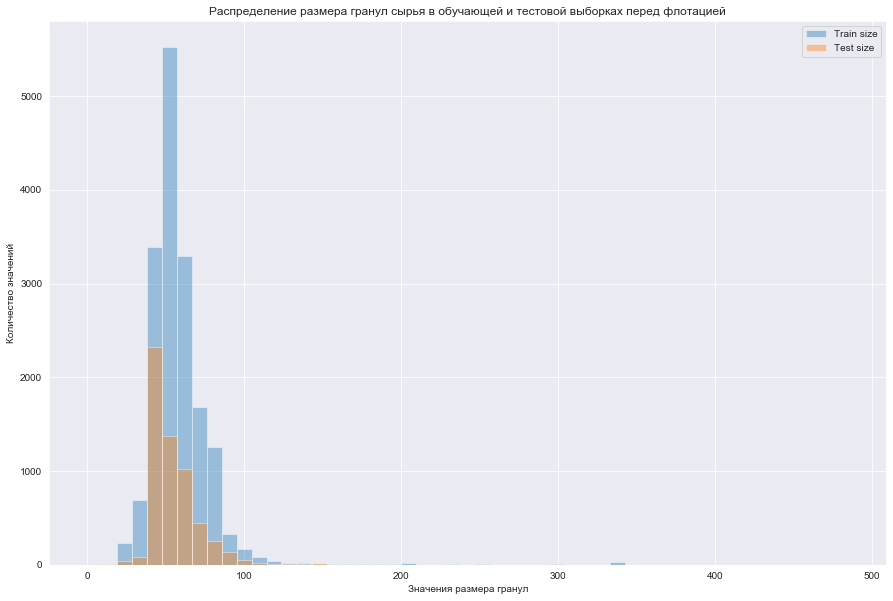

In [50]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

sns.distplot(train['rougher.input.feed_size'], label='Train size', kde=False)
sns.distplot(test['rougher.input.feed_size'], label='Test size', kde=False)
plt.legend()
plt.title('Распределение размера гранул сырья в обучающей и тестовой выборках перед флотацией')
plt.xlabel('Значения размера гранул')
plt.ylabel('Количество значений');

In [51]:
# вычислим средние размера гранул до флотации для трейна и теста

print('Размер гранул до флотации для трейна: {}'.format(train['rougher.input.feed_size'].mean()))
print('Размер гранул до флотации для теста: {}'.format(test['rougher.input.feed_size'].mean()))

Размер гранул до флотации для трейна: 58.67644376412438
Размер гранул до флотации для теста: 55.93753506406796


In [52]:
# найдем доверительные интервалы для средних

from scipy import stats as st

conf_interval_train = st.t.interval(0.95, len(train['rougher.input.feed_size'])-1,
                             loc=train['rougher.input.feed_size'].mean(),
                             scale=train['rougher.input.feed_size'].sem())

print('Доверительный интервал для трейна: {}'.format(conf_interval_train))

conf_interval_test = st.t.interval(0.95, len(test['rougher.input.feed_size'])-1,
                             loc=test['rougher.input.feed_size'].mean(),
                             scale=test['rougher.input.feed_size'].sem())

print('Доверительный интервал для теста: {}'.format(conf_interval_test))

Доверительный интервал для трейна: (58.3198119242436, 59.033075604005155)
Доверительный интервал для теста: (55.356490404009946, 56.51857972412597)


**Доверительные интервалы не пересекаются - следовательно размеры гранул различные и оценка модели будет не правильной!!!**

2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Есть ли аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишем выводы и удалим аномалии.

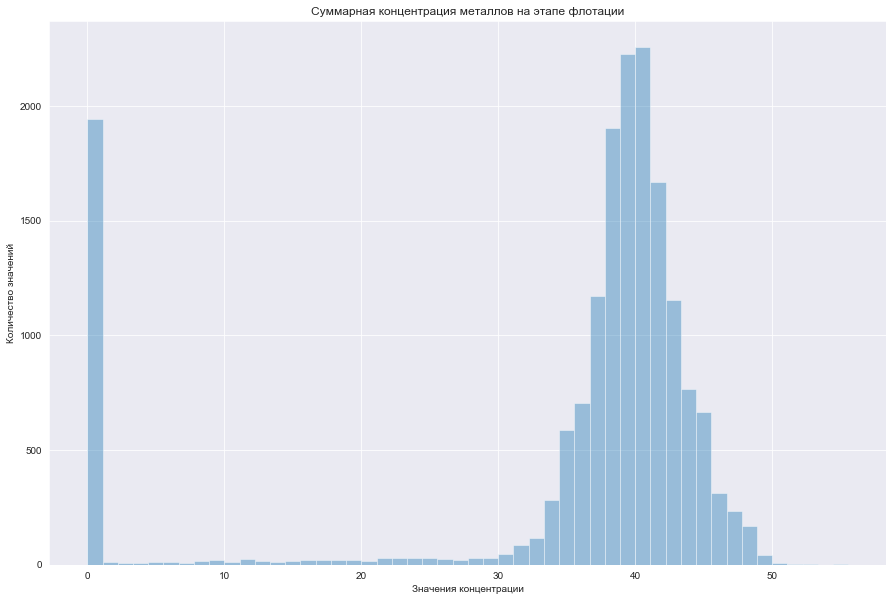

In [53]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

roug_train_sum = train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_ag']

sns.distplot(roug_train_sum, kde=False)
plt.title('Суммарная концентрация металлов на этапе флотации')
plt.xlabel('Значения концентрации')
plt.ylabel('Количество значений');

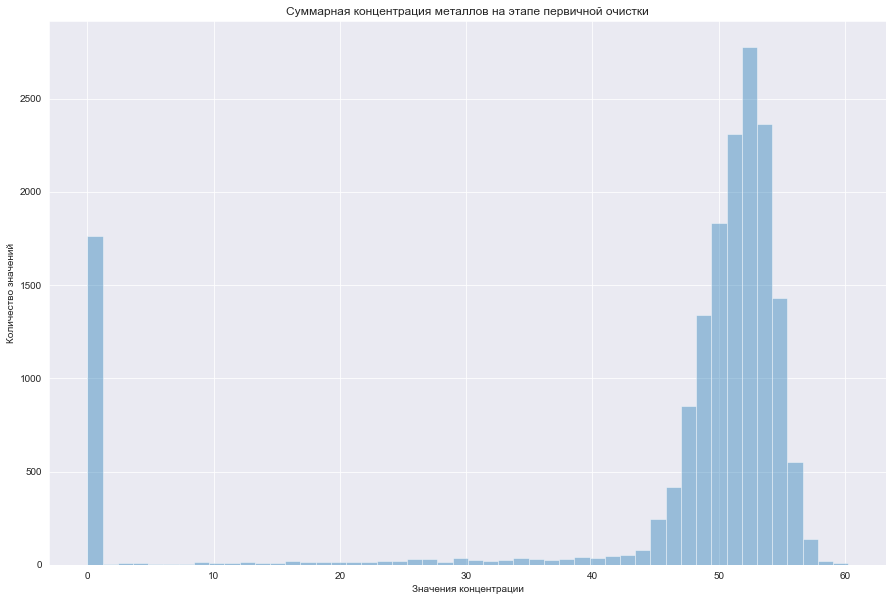

In [54]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

roug_train_sum = train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_au'] \
            + train['primary_cleaner.output.concentrate_ag']

sns.distplot(roug_train_sum, kde=False)
plt.title('Суммарная концентрация металлов на этапе первичной очистки')
plt.xlabel('Значения концентрации')
plt.ylabel('Количество значений');

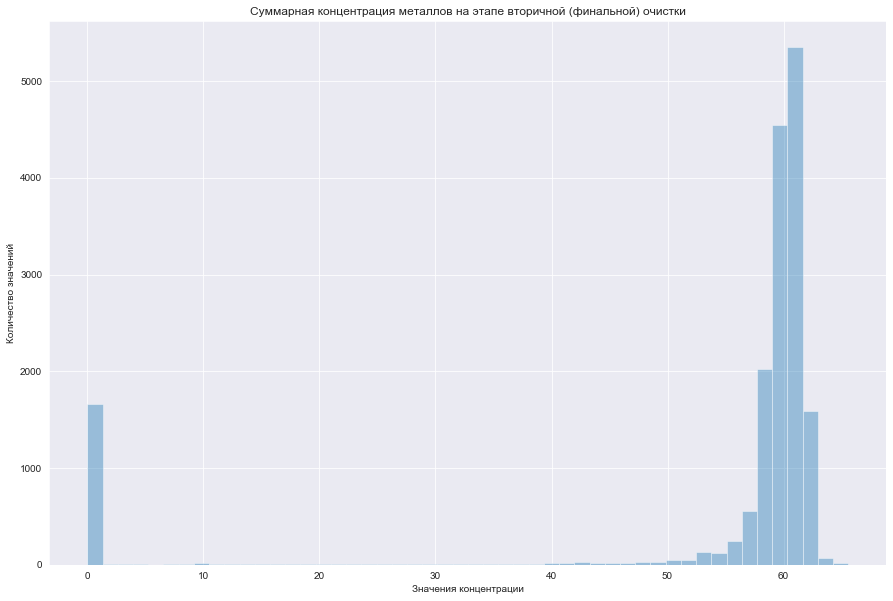

In [55]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')

roug_train_sum = train['final.output.concentrate_pb'] + train['final.output.concentrate_au'] \
            + train['final.output.concentrate_ag']

sns.distplot(roug_train_sum, kde=False)
plt.title('Суммарная концентрация металлов на этапе вторичной (финальной) очистки')
plt.xlabel('Значения концентрации')
plt.ylabel('Количество значений');

**Аномалии - это нулевые значений. Они есть и в трейне и в полном наборе. Удалим из обоих выборок.**

In [56]:
train_new = train[(train['rougher.output.concentrate_pb'] != 0) & (train['rougher.output.concentrate_au'] != 0) & \
      (train['rougher.output.concentrate_ag'] != 0) & (train['primary_cleaner.output.concentrate_pb'] != 0) & \
      (train['primary_cleaner.output.concentrate_au'] != 0) & (train['primary_cleaner.output.concentrate_ag'] != 0) & \
      (train['final.output.concentrate_pb'] != 0) & (train['final.output.concentrate_au'] != 0) & (train['final.output.concentrate_ag'] != 0)]

In [57]:
train_new.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [58]:
train_new.shape, train.shape

((15111, 87), (16860, 87))

In [59]:
full_new = full[(full['rougher.output.concentrate_pb'] != 0) & (full['rougher.output.concentrate_au'] != 0) & \
      (full['rougher.output.concentrate_ag'] != 0) & (full['primary_cleaner.output.concentrate_pb'] != 0) & \
      (full['primary_cleaner.output.concentrate_au'] != 0) & (full['primary_cleaner.output.concentrate_ag'] != 0) & \
      (full['final.output.concentrate_pb'] != 0) & (full['final.output.concentrate_au'] != 0) & (full['final.output.concentrate_ag'] != 0)]

In [60]:
full_new.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [61]:
full_new.shape, full.shape

((20389, 87), (22716, 87))

### Вывод: 

Доверительные интервалы для размера гранул не пересекаются.

Концентрация золота растет после каждого этапа очистки.

Удалили нулевые значения концентраций металлов по всем этапам очистки, посчитав их аномалиями.

# 3. Модель

3.1. Напишем функцию для вычисления итоговой sMAPE.

Напомним формулу для sMAPE:

<div style="text-align: center;"> $sMAPE = 1/N * Sum_1^N ( (|y_i - y_i^-|) / ( (|y_i| + |y_i^-|)/2) ) * 100$ </div>
    
где:
- Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество - y_i;
- Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке - y_i^-;

In [62]:
def sMAPE(target, pred):
    return 1/len(target) * sum( ( (abs(target - pred)) / ( (abs(target) + abs(pred)) / 2 ) ) * 100 )

In [63]:
def final_sMAPE(rouger, final):
    return 0.25 * sMAPE(rouger[0], rouger[1]) + 0.75 * sMAPE(final[0], final[1])

3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберим лучшую модель и проверим её на тестовой выборке. Опишим выводы.

Сначала посмотри еще раз на трейн и тест, затем определим признаки на которых будем обучаться.

In [64]:
len(train.columns), train.columns

(87,
 Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
        'final.output.concentrate_sol', 'final.output.concentrate_au',
        'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
        'final.output.tail_sol', 'final.output.tail_au',
        'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
        'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.concentrate_sol',
        'primary_cleaner.output.concentrate_au',
        'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
        'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_b_level',


In [65]:
len(test.columns), test.columns

(53,
 Index(['date', 'primary_cleaner.input.sulfate',
        'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
        'primary_cleaner.input.xanthate',
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_b_level',
        'primary_cleaner.state.floatbank8_c_air',
        'primary_cleaner.state.floatbank8_c_level',
        'primary_cleaner.state.floatbank8_d_air',
        'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
        'rougher.input.feed_pb', 'rougher.input.feed_rate',
        'rougher.input.feed_size', 'rougher.input.feed_sol',
        'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
        'rougher.input.floatbank10_xanthate',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
        'rougher.state.floatb

In [66]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [67]:
# воспользуемся ранее выбранным датасетом для обучения модели
train_to_model.head().T

,0,1,2,3,4
secondary_cleaner.state.floatbank2_a_level,-498.526,-499.99,-499.93,-499.177,-500.279
secondary_cleaner.state.floatbank5_a_level,-498.31,-500.17,-500.129,-499.202,-501.687
rougher.input.feed_au,6.48615,6.47858,6.36222,6.11819,5.66371
primary_cleaner.input.feed_size,7.25,7.25,7.25,7.25,7.25
secondary_cleaner.state.floatbank5_b_air,8.07967,7.98476,8.01388,7.97732,7.89424
secondary_cleaner.state.floatbank2_a_air,25.8531,25.8805,26.0052,25.9425,26.0248
rougher.state.floatbank10_d_level,-451.294,-449.954,-449.954,-450.13,-449.91
rougher.input.feed_ag,6.10038,6.16111,6.11645,6.04331,6.06092
secondary_cleaner.state.floatbank2_b_air,23.8937,23.8895,23.8867,23.9555,23.9553
secondary_cleaner.state.floatbank4_b_air,12.0999,11.9505,11.9128,11.9996,11.9531


In [68]:
sorted(list(train_to_model.columns))

['date',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In [69]:
# удалим дату - т.к. не информативный признак - у нас не времянной ряд и нет зависимости от даты.

train_to_model = train_to_model.drop(['date'], axis=1)

Составим обучающую и валидационные наборы данных, а также целевые переменные для флотации и финальной очистки.

In [70]:
list_rougher = ['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_rate',
                'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.floatbank10_sulfate',
                'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
                'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
                'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
                'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
                'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
split = int(len(train_to_model)*0.75)

#X_train_rougher = train_to_model.loc[:split, list_rougher]
#X_val_rougher = train_to_model.loc[split:, list_rougher]

X_train = train_to_model.iloc[:split, :]
X_val = train_to_model.iloc[split:, :]

In [73]:
y_train_rougher = train['rougher.output.recovery'].iloc[:split]
y_val_rougher = train['rougher.output.recovery'].iloc[split:]
y_train_final = train['final.output.recovery'].iloc[:split]
y_val_final = train['final.output.recovery'].iloc[split:]

In [74]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

In [75]:
X_train.head()

,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank5_a_level,rougher.input.feed_au,primary_cleaner.input.feed_size,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank2_a_air,rougher.state.floatbank10_d_level,rougher.input.feed_ag,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_a_level,primary_cleaner.state.floatbank8_a_level,rougher.state.floatbank10_f_level,rougher.state.floatbank10_d_air,rougher.input.floatbank10_sulfate,rougher.input.feed_size,primary_cleaner.state.floatbank8_b_level,primary_cleaner.input.depressant,rougher.input.feed_rate,rougher.state.floatbank10_f_air,rougher.state.floatbank10_a_level,primary_cleaner.input.sulfate,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank6_a_level,primary_cleaner.state.floatbank8_b_air,rougher.input.feed_sol,primary_cleaner.state.floatbank8_d_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_b_level,rougher.state.floatbank10_e_air,primary_cleaner.state.floatbank8_c_level,rougher.input.feed_pb,rougher.input.floatbank11_xanthate,secondary_cleaner.state.floatbank3_b_air,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,secondary_cleaner.state.floatbank6_a_air,rougher.input.floatbank11_sulfate,primary_cleaner.state.floatbank8_c_air,secondary_cleaner.state.floatbank2_b_level,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_d_level,rougher.state.floatbank10_a_air,rougher.state.floatbank10_b_level,secondary_cleaner.state.floatbank4_a_air,rougher.state.floatbank10_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank5_a_air,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_e_level,secondary_cleaner.state.floatbank3_a_level
0,0.203002,-0.033664,-0.286866,-0.235909,-0.576752,-0.146056,0.221447,-0.570076,0.126170,-0.274212,-0.160628,0.106815,0.190949,1.185292,0.085957,-0.025089,-0.104662,0.401614,0.722946,1.408750,0.019373,0.002521,-0.033878,-1.061547,0.094104,0.427463,0.211720,-0.402505,-0.085425,1.149015,0.122996,-0.604382,0.353930,0.040140,0.903056,0.305899,-0.709459,0.215481,0.123146,0.192896,0.446380,0.095891,0.099706,-0.154683,0.399473,-0.539429,0.903604,-0.386862,-0.723499,0.471008,0.134106,-0.108544
1,0.187563,-0.056625,-0.289412,-0.235909,-0.591705,-0.142663,0.240491,-0.550503,0.125669,-0.298937,-0.194433,0.081250,0.214877,1.189901,0.082067,0.045432,0.102613,0.448802,0.734209,1.352123,0.054526,-0.031329,-0.035282,-0.984289,0.158872,0.335757,0.255664,-0.366915,-0.086735,1.131738,0.114959,-0.617540,0.359564,0.060733,0.897826,0.201470,-0.731051,0.248412,0.189022,0.203906,0.480901,0.165674,0.039153,-0.152718,0.199113,-0.543466,0.897192,-0.385794,-0.706852,0.469827,0.195344,-0.163017
2,0.188196,-0.056120,-0.328560,-0.235909,-0.587117,-0.127237,0.240484,-0.564895,0.125320,-0.305184,-0.160997,0.092888,0.209513,1.187935,0.069308,0.054560,0.093315,0.735384,0.764790,1.354156,0.054448,-0.073202,-0.041314,-1.005217,0.223429,0.354724,0.310424,-0.364832,-0.085974,1.131586,0.095688,-0.691699,0.519256,0.326035,0.895600,0.199774,-0.726773,0.232742,0.254618,0.208384,0.452603,0.232809,0.029298,-0.154640,0.198389,-0.539728,0.893164,-0.392750,-0.702212,0.571606,0.207773,-0.155753
3,0.196141,-0.044669,-0.410661,-0.235909,-0.592876,-0.134998,0.237984,-0.588469,0.133681,-0.290824,-0.142346,0.080650,0.219190,1.181779,-0.003959,0.065661,0.104979,0.737030,0.845916,1.353877,0.053340,-0.109063,-0.041881,-0.986955,0.224149,0.432125,0.312408,-0.365466,-0.082890,1.137391,0.097448,-0.776593,0.512557,0.325571,0.896538,0.200376,-0.730035,0.185675,0.250332,0.209482,0.466192,0.228611,0.026821,-0.154318,0.190350,-0.536194,0.895216,-0.386247,-0.716944,0.574687,0.206539,-0.162151
4,0.184509,-0.075351,-0.563566,-0.235909,-0.605965,-0.124819,0.241114,-0.582794,0.133660,-0.298517,-0.130925,0.106003,0.211091,1.187674,-0.173524,-0.003029,0.096881

In [76]:
scaler.fit(X_val)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

In [77]:
X_val.head()

,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank5_a_level,rougher.input.feed_au,primary_cleaner.input.feed_size,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank2_a_air,rougher.state.floatbank10_d_level,rougher.input.feed_ag,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_a_level,primary_cleaner.state.floatbank8_a_level,rougher.state.floatbank10_f_level,rougher.state.floatbank10_d_air,rougher.input.floatbank10_sulfate,rougher.input.feed_size,primary_cleaner.state.floatbank8_b_level,primary_cleaner.input.depressant,rougher.input.feed_rate,rougher.state.floatbank10_f_air,rougher.state.floatbank10_a_level,primary_cleaner.input.sulfate,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank6_a_level,primary_cleaner.state.floatbank8_b_air,rougher.input.feed_sol,primary_cleaner.state.floatbank8_d_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_b_level,rougher.state.floatbank10_e_air,primary_cleaner.state.floatbank8_c_level,rougher.input.feed_pb,rougher.input.floatbank11_xanthate,secondary_cleaner.state.floatbank3_b_air,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,secondary_cleaner.state.floatbank6_a_air,rougher.input.floatbank11_sulfate,primary_cleaner.state.floatbank8_c_air,secondary_cleaner.state.floatbank2_b_level,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_d_level,rougher.state.floatbank10_a_air,rougher.state.floatbank10_b_level,secondary_cleaner.state.floatbank4_a_air,rougher.state.floatbank10_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank5_a_air,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_e_level,secondary_cleaner.state.floatbank3_a_level
0,0.254286,0.234208,-2.215393,0.933196,-0.993531,-0.436913,0.004212,-2.400593,-0.117330,-0.606007,0.183207,0.023036,0.042522,-0.994209,0.438261,-2.067860,0.061657,-2.362697,-0.578013,-0.386679,0.199416,-0.170767,0.227121,0.264961,0.387514,-3.050162,0.502362,0.117651,0.232747,-0.532827,0.075570,-2.209769,-0.619735,-0.123110,-0.823399,0.145016,-0.874070,0.242271,0.375370,0.245266,-2.343922,0.406434,-0.022109,0.883350,0.135781,-0.733486,-0.673992,-0.697515,-1.252206,-3.294611,0.225312,-1.445874
1,0.250273,0.236767,-2.215393,0.933196,-0.998260,-0.440400,0.375995,-2.400593,-0.134292,-0.612728,0.189006,-0.027055,0.256320,-0.987874,0.438261,-2.390410,0.061134,-2.364945,-0.578013,-0.380768,0.251525,-0.170767,0.226813,0.270835,0.389273,-3.050162,0.503187,0.121267,0.234348,-0.524494,-0.073159,-2.209769,-0.619735,-0.117092,-0.815449,0.273294,-0.872202,0.242271,0.375175,0.226131,-2.351751,0.408546,-0.018219,0.879634,0.284381,-0.731845,-0.669397,-0.696319,-1.245947,-0.399120,0.181483,-1.531074
2,0.308758,0.254949,-2.215393,0.933196,-0.986915,-0.439654,0.263459,-2.400593,-0.125236,-0.619290,0.329516,0.121171,0.308346,-1.005095,0.438261,-2.499214,0.085273,-2.367193,-0.578013,-0.386844,0.260124,-0.170767,0.231459,0.287938,0.400007,-3.050162,0.488501,0.140333,0.236542,-0.532404,0.421162,-2.209769,-0.619735,-0.118199,-0.826011,0.330869,-0.875710,0.242271,0.371761,0.258900,-2.360102,0.405442,0.357212,0.874463,0.223134,-0.732173,-0.670321,-0.695120,-1.241049,-3.303293,0.239324,0.119139
3,0.256250,0.231225,-2.215393,0.933196,-0.993021,-0.443677,0.128242,-2.400593,-0.134581,-0.619687,0.184392,-0.009238,0.081283,-1.018430,0.438261,-2.485172,0.060586,-2.369441,-0.578013,-0.396199,0.233286,-0.170767,0.224219,0.257004,0.394137,-3.050162,0.506458,0.115477,0.229369,-0.537099,-0.167062,-2.209769,-0.619735,-0.125462,-0.823487,0.170996,-0.873049,0.242271,0.372578,0.269771,-0.261051,0.409124,-0.038236,0.883123,0.208717,-0.731324,-0.670213,-0.698932,-1.252269,-0.399120,0.188126,0.241149
4,0.253148,0.227816,-0.938824,0.933196,-0.992045,-0.455281,0.211725,-1.033337,-0.123160,-0.616473,0.183925,0.019407,0.191328,-1.019292,-2

Выберем для обучения следующие модели - SGD, LinearRegression

In [78]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_rougher)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [80]:
lin_reg.predict(X_val)

array([70.25832703, 71.5845452 , 71.66823155, ..., 79.71681064,
       78.97434529, 78.01500855])

In [81]:
mean_absolute_error(lin_reg.predict(X_val), y_val_rougher)

9.264795427289512

In [82]:
sgd = SGDRegressor(loss='squared_loss')
sgd.fit(X_train, y_train_rougher)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [83]:
sgd.predict(X_val)

array([70.32568829, 71.72092474, 71.43784606, ..., 77.7231811 ,
       76.93594861, 75.77171346])

In [84]:
mean_absolute_error(sgd.predict(X_val), y_val_rougher)

9.475965349234105

**Качество SGD лучше, будем тюнить дальше его**

In [85]:
sgd_params = {
    'alpha' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
}

sgd = SGDRegressor(random_state=42, verbose=0, loss='huber')

In [86]:
sgd_rougher = GridSearchCV(sgd, sgd_params, cv=5)

In [87]:
%time sgd_rougher.fit(X_train, y_train_rougher)

Wall time: 31.6 s


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='huber', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=42, shuffle=True,
                                    tol=0.001, validation_fraction=0.1,
                                    verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [88]:
 sgd_rougher.best_params_, sgd_rougher.best_estimator_

({'alpha': 0.01},
 SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.01, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='huber', max_iter=1000,
              n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False))

In [89]:
sgd_rougher_preds = sgd_rougher.predict(X_val)

In [90]:
mean_absolute_error(sgd_rougher_preds, y_val_rougher)

7.499469114785231

In [91]:
from sklearn.metrics import mean_squared_error

In [92]:
mean_squared_error(sgd_rougher_preds, y_val_rougher)

82.82874435826415

**Случайный лес явно лучше.**

In [93]:
# создадим тестовые наборы

X_test = test.drop(['date'], axis=1)
X_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986,24.893998,-499.382374,14.916674,-

In [94]:
scaler.fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [95]:
X_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.833931,1.990601,1.333416,-0.463052,-0.267769,0.144199,-0.280602,0.176372,-0.220955,0.144403,-0.278983,0.172046,1.473234,1.573787,0.201454,0.298635,0.644580,1.208719,0.891084,-0.009708,0.844700,-0.251254,-0.063876,0.542387,-0.073242,1.501235,-0.012901,1.519144,0.100405,1.506039,-0.081766,1.151189,-0.056408,1.166633,-0.099549,0.212067,-1.035095,0.194547,-0.545944,0.934486,-0.796645,1.079953,-0.776198,0.294743,-1.193403,-0.236728,-1.161029,1.359160,-1.390251,0.072510,1.858031,0.181074
1,0.928978,1.988874,1.333416,-0.484349,-0.268425,0.146944,-0.284086,0.178483,-0.233722,0.167800,-0.277366,0.157790,1.442279,1.490230,0.203454,0.265597,0.566807,1.149723,0.911463,-0.102978,0.873188,-0.387900,-0.077843,0.541152,-0.077958,1.486077,-0.013714,1.514784,0.108191,1.497770,-0.079475,1.151778,-0.053534,1.055168,-0.102257,0.222923,-1.037918,0.182687,-0.549686,0.938303,-0.782769,1.076182,-0.768767,0.280382,-1.166803,-0.221026,-1.157913,-0.231911,-1.388334,0.070691,1.545625,0.179498
2,0.926235,1.345993,0.853701,-0.476192,-0.269342,0.133705,-0.281512,0.178687,-0.227504,0.121278,-0.277402,0.168519,1.476535,1.415087,0.200323,0.483531,0.693400,1.211301,0.908902,-0.192609,0.870093,-0.524846,-0.078613,0.547523,-0.081310,1.480323,-0.018218,1.487892,0.105606,1.482318,-0.079806,1.155582,-0.052987,1.127310,-0.104965,0.215064,-1.026845,0.179062,-0.543229,0.936284,-0.784747,1.082778,-0.789345,0.279238,-1.174734,-0.232347,-1.127896,0.194056,-1.380390,0.075551,1.540978,0.167995
3,0.927815,1.077493,0.613843,-0.670148,-0.265715,0.166436,-0.286053,0.186943,-0.220870,0.181930,-0.272396,0.148262,1.229038,1.179619,0.116675,0.173212,0.554906,1.243551,0.791118,-0.222020,0.766636,-0.570830,-0.070831,0.543663,-0.067680,1.509410,-0.010340,1.512624,0.104303,1.542213,-0.071138,1.137638,-0.051106,1.142862,-0.107673,0.229845,-1.040313,0.196942,-0.544313,0.948342,-0.793120,1.084999,-0.774149,0.285885,-1.179840,-0.219510,-1.174197,0.192919,-1.372447,0.073584,1.532465,0.195389
4,0.591703,0.672577,0.433950,-0.754943,-0.260392,0.134685,-0.283851,0.182565,-0.214270,0.142705,-0.277455,0.173746,0.869121,0.917288,0.191509,0.325305,0.574380,0

In [96]:
full.shape[0], test.shape[0]

(22716, 5856)

In [97]:
index = full.shape[0] - test.shape[0]
index

y_test_rougher = full['rougher.output.recovery'].iloc[index:]
y_test_final = full['final.output.recovery'].iloc[index:]

In [98]:
y_test_rougher.shape

(5856,)

In [99]:
y_test_rougher.head()

16860    44.121694
16861    72.328628
16862    87.873605
16863    92.444278
16864    91.889109
Name: rougher.output.recovery, dtype: float64

In [100]:
sgd_rougher_preds_rougher = sgd_rougher.predict(X_test)

In [101]:
sgd_rougher_preds_rougher

array([81.14955186, 80.83679165, 80.48508949, ..., 82.61559075,
       82.7803167 , 82.86356861])

In [102]:
mean_squared_error(sgd_rougher_preds_rougher, y_test_rougher), mean_absolute_error(sgd_rougher_preds_rougher, y_test_rougher)

(224.13798827601855, 9.084181313379085)

In [103]:
%time sgd_rougher.fit(X_train, y_train_final)

Wall time: 23.3 s


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='huber', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=42, shuffle=True,
                                    tol=0.001, validation_fraction=0.1,
                                    verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [104]:
sgd_rougher_preds_final = sgd_rougher.predict(X_test)

In [105]:
sgd_rougher_preds_final

array([65.13685596, 64.91427578, 64.86243313, ..., 65.89972258,
       65.93902099, 65.95986478])

In [106]:
mean_squared_error(sgd_rougher_preds_final, y_test_final), mean_absolute_error(sgd_rougher_preds_final, y_test_final)

(192.22304719423815, 9.743268451614199)

In [107]:
rougher = (y_test_rougher.values, sgd_rougher_preds_rougher)
final = (y_test_final.values, sgd_rougher_preds_final)

In [108]:
rougher

(array([44.12169388, 72.32862842, 87.87360516, ..., 88.89057853,
        89.858126  , 89.51495973]),
 array([81.14955186, 80.83679165, 80.48508949, ..., 82.61559075,
        82.7803167 , 82.86356861]))

In [109]:
final

(array([ 0.        ,  0.        , 72.74492745, ..., 67.00218885,
        65.52324622, 70.28145415]),
 array([65.13685596, 64.91427578, 64.86243313, ..., 65.89972258,
        65.93902099, 65.95986478]))

In [110]:
print(final_sMAPE(rougher, final))

13.926039016741278


### Вывод:

Очень много неоднозначности по поводу построения модели и признаков.

Модель была принята - стохастический градиентный бустинг. Лучшее значение финальной sMAPE - 13,98.